# Fine-tuning XLM-RoBERTa for Multilingual NER - Sequential Training

## Overview
This notebook fine-tunes a multilingual transformer model using **sequential language training** on English, French, and Italian LitBank datasets.

**Training Approach: Sequential Language Addition**
- Train on English data → Evaluate on all three test sets
- Continue training on French data (keeping EN weights) → Evaluate on all three test sets  
- Continue training on Italian data (keeping EN+FR weights) → Evaluate on all three test sets

This approach allows us to observe how the model's cross-lingual performance evolves as we incrementally add training data from each language.

**Content**
1. Load preprocessed English, French, and Italian data from Notebook 1
2. Configure XLM-RoBERTa for token classification
3. Handle subword tokenization
4. Sequential training: EN → FR → IT
5. Evaluate on all three test sets after each training stage
6. Visualize performance evolution across training stages
7. Compare cross-lingual transfer effects

**Model: XLM-RoBERTa**
- Multilingual (Pre-trained on 100 languages)
- State-of-the-art performance on sequence labeling
- Enables cross-lingual transfer learning

In [1]:
# Import required libraries
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple
from tqdm.auto import tqdm

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from datasets import Dataset

# Evaluation metrics
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

✓ Libraries imported


In [10]:
# Configure paths
PROCESSED_DATA_PATH = Path("../data/processed")
MODEL_OUTPUT_PATH = Path("../models")
RESULTS_PATH = Path("../results")

MODEL_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Model configuration
MODEL_NAME = "xlm-roberta-base"  # Multilingual model
MAX_LENGTH = 512  # Maximum sequence length (tokens)
BATCH_SIZE = 16   # Adjust based on your GPU memory (8/16/32)
LEARNING_RATE = 2e-5  # Standard for fine-tuning transformers
NUM_EPOCHS = 3    # Typically 3-5 epochs for NER

print(f"✓ Configuration loaded")
print(f"  Model: {MODEL_NAME}")
print(f"  Max length: {MAX_LENGTH} tokens")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

✓ Configuration loaded
  Model: xlm-roberta-base
  Max length: 512 tokens
  Batch size: 16
  Learning rate: 2e-05
  Epochs: 3


## 1. Load Preprocessed Data

Load the JSON files created in Notebook 1. For sequential training, we keep the language datasets separate.

In [3]:
def load_processed_data(data_path: Path) -> Dict:
    """
    Load preprocessed JSON data and convert to Hugging Face Dataset format.
    Returns separate datasets for each language for sequential training.
    
    Returns:
        Dictionary containing:
        - label_mapping: {"label2id": {...}, "id2label": {...}}
        - english: {"train": Dataset, "dev": Dataset, "test": Dataset}
        - french: {"train": Dataset, "dev": Dataset, "test": Dataset}
        - italian: {"train": Dataset, "dev": Dataset, "test": Dataset}
    """
    # Load label mapping
    with open(data_path / "label_mapping.json", 'r', encoding='utf-8') as f:
        label_mapping = json.load(f)
    
    # Load English datasets
    with open(data_path / "english_train.json", 'r', encoding='utf-8') as f:
        english_train = json.load(f)
    with open(data_path / "english_dev.json", 'r', encoding='utf-8') as f:
        english_dev = json.load(f)
    with open(data_path / "english_test.json", 'r', encoding='utf-8') as f:
        english_test = json.load(f)
    
    # Load French datasets
    with open(data_path / "french_train.json", 'r', encoding='utf-8') as f:
        french_train = json.load(f)
    with open(data_path / "french_dev.json", 'r', encoding='utf-8') as f:
        french_dev = json.load(f)
    with open(data_path / "french_test.json", 'r', encoding='utf-8') as f:
        french_test = json.load(f)
    
    # Load Italian datasets
    with open(data_path / "italian_train.json", 'r', encoding='utf-8') as f:
        italian_train = json.load(f)
    with open(data_path / "italian_dev.json", 'r', encoding='utf-8') as f:
        italian_dev = json.load(f)
    with open(data_path / "italian_test.json", 'r', encoding='utf-8') as f:
        italian_test = json.load(f)
    
    # Convert to Hugging Face Dataset format
    data = {
        "label_mapping": label_mapping,
        "english": {
            "train": Dataset.from_list(english_train),
            "dev": Dataset.from_list(english_dev),
            "test": Dataset.from_list(english_test),
            "raw_test": english_test  # Keep raw for visualization
        },
        "french": {
            "train": Dataset.from_list(french_train),
            "dev": Dataset.from_list(french_dev),
            "test": Dataset.from_list(french_test),
            "raw_test": french_test
        },
        "italian": {
            "train": Dataset.from_list(italian_train),
            "dev": Dataset.from_list(italian_dev),
            "test": Dataset.from_list(italian_test),
            "raw_test": italian_test
        }
    }
    
    print(f"✓ Loaded preprocessed data from {data_path}")
    print(f"\nEnglish datasets:")
    print(f"  Train: {len(english_train)} examples")
    print(f"  Dev:   {len(english_dev)} examples")
    print(f"  Test:  {len(english_test)} examples")
    print(f"\nFrench datasets:")
    print(f"  Train: {len(french_train)} examples")
    print(f"  Dev:   {len(french_dev)} examples")
    print(f"  Test:  {len(french_test)} examples")
    print(f"\nItalian datasets:")
    print(f"  Train: {len(italian_train)} examples")
    print(f"  Dev:   {len(italian_dev)} examples")
    print(f"  Test:  {len(italian_test)} examples")
    print(f"\nLabels: {len(label_mapping['label2id'])} unique tags")
    
    return data


# Load data
data = load_processed_data(PROCESSED_DATA_PATH)

# Extract label mappings
label_mapping = data["label_mapping"]
id2label = {int(k): v for k, v in label_mapping["id2label"].items()}
label2id = label_mapping["label2id"]

print(f"\nLabel mapping preview:")
for idx in sorted(id2label.keys())[:10]:
    print(f"  {idx}: {id2label[idx]}")

✓ Loaded preprocessed data from ../data/processed

English datasets:
  Train: 5577 examples
  Dev:   747 examples
  Test:  693 examples

French datasets:
  Train: 5130 examples
  Dev:   1313 examples
  Test:  1406 examples

Italian datasets:
  Train: 7493 examples
  Dev:   927 examples
  Test:  840 examples

Labels: 15 unique tags

Label mapping preview:
  0: O
  1: B-FAC
  2: B-GPE
  3: B-LOC
  4: B-ORG
  5: B-PER
  6: B-TIME
  7: B-VEH
  8: I-FAC
  9: I-GPE


## 2. Tokenization and Label Alignment

Transformers use subword tokenization (WordPiece/BPE), while labels correspond to words. Which subwords get the label?

**First-token strategy** : the first subword receives the label, subsequent tokens will be ignored (the `-100` label tells PyTorch to ignore these tokens when computing loss.)

In [4]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Loaded tokenizer: {MODEL_NAME}")

# Example: Show subword tokenization
example_text = "Elizabeth Bennet lived in Pemberley in the lake district of northern England."
tokens = tokenizer.tokenize(example_text)
print(f"\nExample tokenization:")
print(f"  Input:  {example_text}")
print(f"  Tokens: {tokens}")

✓ Loaded tokenizer: xlm-roberta-base

Example tokenization:
  Input:  Elizabeth Bennet lived in Pemberley in the lake district of northern England.
  Tokens: ['▁Elizabeth', '▁Ben', 'net', '▁lived', '▁in', '▁Pembe', 'r', 'ley', '▁in', '▁the', '▁lake', '▁district', '▁of', '▁north', 'ern', '▁England', '.']


In [5]:
def tokenize_and_align_labels(examples: Dict) -> Dict:
    """
    Tokenize input and align NER labels with subword tokens.
    
    WHY: This is the most critical function for NER with transformers!
    Without proper alignment, your model will learn incorrect labels.
    
    Process:
    1. Tokenize words into subwords
    2. For each subword, determine which original word it came from
    3. Assign labels:
       - First subword of word → original label
       - Continuation subwords → -100 (ignored)
       - Special tokens ([CLS], [SEP]) → -100 (ignored)
    
    Args:
        examples: Batch of examples with "tokens" and "ner_tags"
        
    Returns:
        Tokenized inputs with aligned labels
    """
    # Tokenize all examples
    # is_split_into_words=True tells tokenizer we already have word tokens
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        max_length=MAX_LENGTH,
        is_split_into_words=True,
        padding=False  # We'll pad dynamically in batches
    )
    
    all_labels = []
    
    # Process each example in the batch
    for i, labels in enumerate(examples["ner_tags"]):
        # word_ids() returns which original word each token came from
        # Example: [None, 0, 1, 1, 2, None] means:
        #   - Token 0: special token ([CLS])
        #   - Token 1: from word 0
        #   - Token 2-3: from word 1 (subwords!)
        #   - Token 4: from word 2
        #   - Token 5: special token ([SEP])
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            # Special tokens (None) → -100
            if word_idx is None:
                label_ids.append(-100)
            
            # First subword of a word → original label
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            
            # Continuation subwords → -100
            else:
                label_ids.append(-100)
            
            previous_word_idx = word_idx
        
        all_labels.append(label_ids)
    
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


print("✓ Tokenization function defined")

✓ Tokenization function defined


In [6]:
# Apply tokenization to all datasets for each language
print("Tokenizing datasets...")

# Tokenize English datasets
tokenized_english = {
    "train": data["english"]["train"].map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["english"]["train"].column_names,
        desc="Tokenizing English train"
    ),
    "dev": data["english"]["dev"].map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["english"]["dev"].column_names,
        desc="Tokenizing English dev"
    ),
    "test": data["english"]["test"].map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["english"]["test"].column_names,
        desc="Tokenizing English test"
    )
}

# Tokenize French datasets
tokenized_french = {
    "train": data["french"]["train"].map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["french"]["train"].column_names,
        desc="Tokenizing French train"
    ),
    "dev": data["french"]["dev"].map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["french"]["dev"].column_names,
        desc="Tokenizing French dev"
    ),
    "test": data["french"]["test"].map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["french"]["test"].column_names,
        desc="Tokenizing French test"
    )
}

# Tokenize Italian datasets
tokenized_italian = {
    "train": data["italian"]["train"].map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["italian"]["train"].column_names,
        desc="Tokenizing Italian train"
    ),
    "dev": data["italian"]["dev"].map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["italian"]["dev"].column_names,
        desc="Tokenizing Italian dev"
    ),
    "test": data["italian"]["test"].map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["italian"]["test"].column_names,
        desc="Tokenizing Italian test"
    )
}

print("\n✓ Tokenization complete!")
print(f"\nDataset sizes after tokenization:")
print(f"  English - Train: {len(tokenized_english['train'])}, Dev: {len(tokenized_english['dev'])}, Test: {len(tokenized_english['test'])}")
print(f"  French  - Train: {len(tokenized_french['train'])}, Dev: {len(tokenized_french['dev'])}, Test: {len(tokenized_french['test'])}")
print(f"  Italian - Train: {len(tokenized_italian['train'])}, Dev: {len(tokenized_italian['dev'])}, Test: {len(tokenized_italian['test'])}")

Tokenizing datasets...


Tokenizing English train:   0%|          | 0/5577 [00:00<?, ? examples/s]

Tokenizing English dev:   0%|          | 0/747 [00:00<?, ? examples/s]

Tokenizing English test:   0%|          | 0/693 [00:00<?, ? examples/s]

Tokenizing French train:   0%|          | 0/5130 [00:00<?, ? examples/s]

Tokenizing French dev:   0%|          | 0/1313 [00:00<?, ? examples/s]

Tokenizing French test:   0%|          | 0/1406 [00:00<?, ? examples/s]

Tokenizing Italian train:   0%|          | 0/7493 [00:00<?, ? examples/s]

Tokenizing Italian dev:   0%|          | 0/927 [00:00<?, ? examples/s]

Tokenizing Italian test:   0%|          | 0/840 [00:00<?, ? examples/s]


✓ Tokenization complete!

Dataset sizes after tokenization:
  English - Train: 5577, Dev: 747, Test: 693
  French  - Train: 5130, Dev: 1313, Test: 1406
  Italian - Train: 7493, Dev: 927, Test: 840


## 3. Load Model

Load XLM-RoBERTa and add a token classification head on top.

In [7]:
# Load pre-trained model
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Since we're adding a new classification head
)

print(f"✓ Loaded model: {MODEL_NAME}")
print(f"  Parameters: {model.num_parameters():,}")
print(f"  Output labels: {model.num_labels}")
print(f"\nModel architecture:")
print(f"  1. XLM-RoBERTa encoder (pre-trained on 100 languages)")
print(f"  2. Token classification head (randomly initialized, will be trained)")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to us

✓ Loaded model: xlm-roberta-base
  Parameters: 277,464,591
  Output labels: 15

Model architecture:
  1. XLM-RoBERTa encoder (pre-trained on 100 languages)
  2. Token classification head (randomly initialized, will be trained)


## 4. Define Evaluation Metrics

**Seqeval**
- Standard NER evaluation library
- Computes entity-level F1 (not token-level)

**Metrics:**
- **Precision**: Of predicted entities, how many were correct?
- **Recall**: Of true entities, how many were found?
- **F1**: Harmonic mean of precision and recall

In [8]:
def compute_metrics(pred):
    """
    Compute evaluation metrics during training.
    
    WHY: This function is called by Trainer after each evaluation.
    It converts model predictions back to BIO tags and computes F1.
    
    Args:
        pred: Predictions object with logits and labels
        
    Returns:
        Dictionary with precision, recall, f1, accuracy
    """
    predictions, labels = pred
    
    # Get predicted class for each token (argmax over logits)
    predictions = np.argmax(predictions, axis=2)
    
    # Convert to BIO tag strings (removing -100 labels)
    true_labels = []
    true_predictions = []
    
    for prediction, label in zip(predictions, labels):
        true_label = []
        true_pred = []
        
        for pred_id, label_id in zip(prediction, label):
            # Skip -100 labels (subwords and special tokens)
            if label_id != -100:
                true_label.append(id2label[label_id])
                true_pred.append(id2label[pred_id])
        
        true_labels.append(true_label)
        true_predictions.append(true_pred)
    
    # Compute entity-level metrics using seqeval
    results = {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }
    
    return results


print("✓ Evaluation metrics defined")
print("  Using seqeval for entity-level F1 scoring")

✓ Evaluation metrics defined
  Using seqeval for entity-level F1 scoring


## 5. Training Configuration

**Key hyperparameters**
- **Learning rate**: How big the update steps are (2e-5 is standard for fine-tuning)
- **Batch size**: Number of examples processed together (larger = faster but more memory)
- **Epochs**: Full passes through training data (3-5 typical for NER)
- **Warmup**: Gradually increase learning rate at start (stabilizes training)
- **Weight decay**: Regularization to prevent overfitting

**Sequential Training Setup**
We'll train on each language in sequence (EN → FR → IT), evaluating on all test sets after each stage to track how performance evolves.

In [11]:
# Data collator (handles dynamic padding)
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True  # Pad to longest sequence in batch
)

# Store results for visualization
sequential_results = {
    "stages": [],  # ["After EN", "After EN+FR", "After EN+FR+IT"]
    "english_test": {"precision": [], "recall": [], "f1": []},
    "french_test": {"precision": [], "recall": [], "f1": []},
    "italian_test": {"precision": [], "recall": [], "f1": []}
}

def get_training_args(stage_name: str, output_subdir: str):
    """Create training arguments for a specific training stage."""
    return TrainingArguments(
        output_dir=str(MODEL_OUTPUT_PATH / "checkpoints" / output_subdir),
        
        # Training hyperparameters
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=NUM_EPOCHS,
        weight_decay=0.01,
        
        # Evaluation and logging
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        
        # Performance
        fp16=False,
        dataloader_num_workers=0,
        
        # Reporting
        report_to="none",
        push_to_hub=False,
        seed=42,
    )


def evaluate_on_all_test_sets(trainer, stage_name: str):
    """
    Evaluate model on all three test sets and store results.
    
    Args:
        trainer: The Trainer object with current model
        stage_name: Name of the training stage (e.g., "After EN")
    
    Returns:
        Dictionary with results for each language
    """
    results = {}
    
    # Evaluate on English test set
    en_results = trainer.evaluate(eval_dataset=tokenized_english["test"])
    results["english"] = {
        "precision": en_results["eval_precision"],
        "recall": en_results["eval_recall"],
        "f1": en_results["eval_f1"]
    }
    
    # Evaluate on French test set
    fr_results = trainer.evaluate(eval_dataset=tokenized_french["test"])
    results["french"] = {
        "precision": fr_results["eval_precision"],
        "recall": fr_results["eval_recall"],
        "f1": fr_results["eval_f1"]
    }
    
    # Evaluate on Italian test set
    it_results = trainer.evaluate(eval_dataset=tokenized_italian["test"])
    results["italian"] = {
        "precision": it_results["eval_precision"],
        "recall": it_results["eval_recall"],
        "f1": it_results["eval_f1"]
    }
    
    # Store in global results
    sequential_results["stages"].append(stage_name)
    for lang in ["english", "french", "italian"]:
        for metric in ["precision", "recall", "f1"]:
            sequential_results[f"{lang}_test"][metric].append(results[lang][metric])
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"EVALUATION RESULTS: {stage_name}")
    print(f"{'='*60}")
    print(f"\n{'Language':<15} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
    print("-" * 60)
    print(f"{'English':<15} {results['english']['precision']:<12.4f} {results['english']['recall']:<12.4f} {results['english']['f1']:<12.4f}")
    print(f"{'French':<15} {results['french']['precision']:<12.4f} {results['french']['recall']:<12.4f} {results['french']['f1']:<12.4f}")
    print(f"{'Italian':<15} {results['italian']['precision']:<12.4f} {results['italian']['recall']:<12.4f} {results['italian']['f1']:<12.4f}")
    
    return results


print("✓ Training configuration ready")
print(f"  Epochs per language: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")

✓ Training configuration ready
  Epochs per language: 3
  Batch size: 16
  Learning rate: 2e-05


## 6. Sequential Training

**Training sequence:**
1. Train on English data → Evaluate on EN, FR, IT test sets
2. Continue training on French data → Evaluate on EN, FR, IT test sets
3. Continue training on Italian data → Evaluate on EN, FR, IT test sets

The model weights are preserved between stages, allowing us to observe cross-lingual transfer effects.

In [12]:
# Stage 1: Train on English
print("="*60)
print("STAGE 1: Training on English")
print("="*60)

# Initialize fresh model from pre-trained weights
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

print(f"✓ Loaded fresh model: {MODEL_NAME}")
print(f"  Parameters: {model.num_parameters():,}")

# Create trainer for English
training_args_en = get_training_args("English", "stage1_english")

trainer = Trainer(
    model=model,
    args=training_args_en,
    train_dataset=tokenized_english["train"],
    eval_dataset=tokenized_english["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("✓ Trainer initialized for English training")

STAGE 1: Training on English


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to us

✓ Loaded fresh model: xlm-roberta-base
  Parameters: 277,464,591
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
✓ Trainer initialized for English training


In [13]:
# Train on English
print("\nStarting English training...")
train_result_en = trainer.train()

print(f"\n✓ English training complete!")
print(f"  Training loss: {train_result_en.metrics['train_loss']:.4f}")

# Evaluate on all test sets after English training
results_after_en = evaluate_on_all_test_sets(trainer, "After EN")


Starting English training...


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.303800,0.220994,0.634309,0.687815,0.659979
2,0.164100,0.205201,0.671504,0.733958,0.701343
3,0.144100,0.193362,0.682237,0.747657,0.713450



✓ English training complete!
  Training loss: 0.2567



EVALUATION RESULTS: After EN

Language        Precision    Recall       F1 Score    
------------------------------------------------------------
English         0.6398       0.6903       0.6641      
French          0.4579       0.5627       0.5049      
Italian         0.3187       0.3870       0.3495      


In [14]:
# Stage 2: Continue training on French (keeping English weights)
print("\n" + "="*60)
print("STAGE 2: Training on French (continuing from EN weights)")
print("="*60)

# Create new trainer with French data, using the current model (with EN weights)
training_args_fr = get_training_args("French", "stage2_french")

trainer = Trainer(
    model=model,  # Same model with EN weights
    args=training_args_fr,
    train_dataset=tokenized_french["train"],
    eval_dataset=tokenized_french["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train on French
print("\nStarting French training...")
train_result_fr = trainer.train()

print(f"\n✓ French training complete!")
print(f"  Training loss: {train_result_fr.metrics['train_loss']:.4f}")

# Evaluate on all test sets after French training
results_after_fr = evaluate_on_all_test_sets(trainer, "After EN+FR")


STAGE 2: Training on French (continuing from EN weights)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

Starting French training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.210100,0.256866,0.667597,0.697522,0.682231
2,0.155800,0.238249,0.679810,0.728863,0.703482
3,0.112600,0.247877,0.689726,0.733965,0.711158



✓ French training complete!
  Training loss: 0.1586



EVALUATION RESULTS: After EN+FR

Language        Precision    Recall       F1 Score    
------------------------------------------------------------
English         0.5705       0.5742       0.5723      
French          0.6101       0.7452       0.6709      
Italian         0.2541       0.2851       0.2687      


In [15]:
# Stage 3: Continue training on Italian (keeping EN+FR weights)
print("\n" + "="*60)
print("STAGE 3: Training on Italian (continuing from EN+FR weights)")
print("="*60)

# Create new trainer with Italian data, using the current model (with EN+FR weights)
training_args_it = get_training_args("Italian", "stage3_italian")

trainer = Trainer(
    model=model,  # Same model with EN+FR weights
    args=training_args_it,
    train_dataset=tokenized_italian["train"],
    eval_dataset=tokenized_italian["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train on Italian
print("\nStarting Italian training...")
train_result_it = trainer.train()

print(f"\n✓ Italian training complete!")
print(f"  Training loss: {train_result_it.metrics['train_loss']:.4f}")

# Evaluate on all test sets after Italian training
results_after_it = evaluate_on_all_test_sets(trainer, "After EN+FR+IT")


STAGE 3: Training on Italian (continuing from EN+FR weights)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

Starting Italian training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.098800,0.112351,0.747246,0.783697,0.765038
2,0.066600,0.120626,0.719910,0.821566,0.767386
3,0.047200,0.120257,0.749123,0.822208,0.783966



✓ Italian training complete!
  Training loss: 0.0803



EVALUATION RESULTS: After EN+FR+IT

Language        Precision    Recall       F1 Score    
------------------------------------------------------------
English         0.4108       0.3935       0.4020      
French          0.3078       0.3299       0.3184      
Italian         0.7296       0.8030       0.7645      


## 7. Save Final Model

Save the final model (trained on EN → FR → IT) for use in Notebook 3.

In [16]:
# Save final model and tokenizer
final_model_path = MODEL_OUTPUT_PATH / "litbank-xlm-roberta-sequential"
trainer.save_model(str(final_model_path))
tokenizer.save_pretrained(str(final_model_path))

print(f"✓ Final model saved to: {final_model_path.absolute()}")
print("\nSaved files:")
for file in final_model_path.iterdir():
    print(f"  - {file.name}")

# Also save the sequential results to JSON for later analysis
import json
with open(RESULTS_PATH / "sequential_training_results.json", 'w') as f:
    json.dump(sequential_results, f, indent=2)
print(f"\n✓ Results saved to: {RESULTS_PATH / 'sequential_training_results.json'}")

✓ Final model saved to: /storage/homefs/nw03x063/CAS_Mod4_NER/notebooks/../models/litbank-xlm-roberta-sequential

Saved files:
  - config.json
  - pytorch_model.bin
  - training_args.bin
  - tokenizer_config.json
  - special_tokens_map.json
  - sentencepiece.bpe.model
  - tokenizer.json

✓ Results saved to: ../results/sequential_training_results.json


## 8. Visualize Performance Evolution

Visualize how precision, recall, and F1 scores evolve across training stages for each language test set.

✓ Saved visualization to ../results/sequential_training_evolution.png


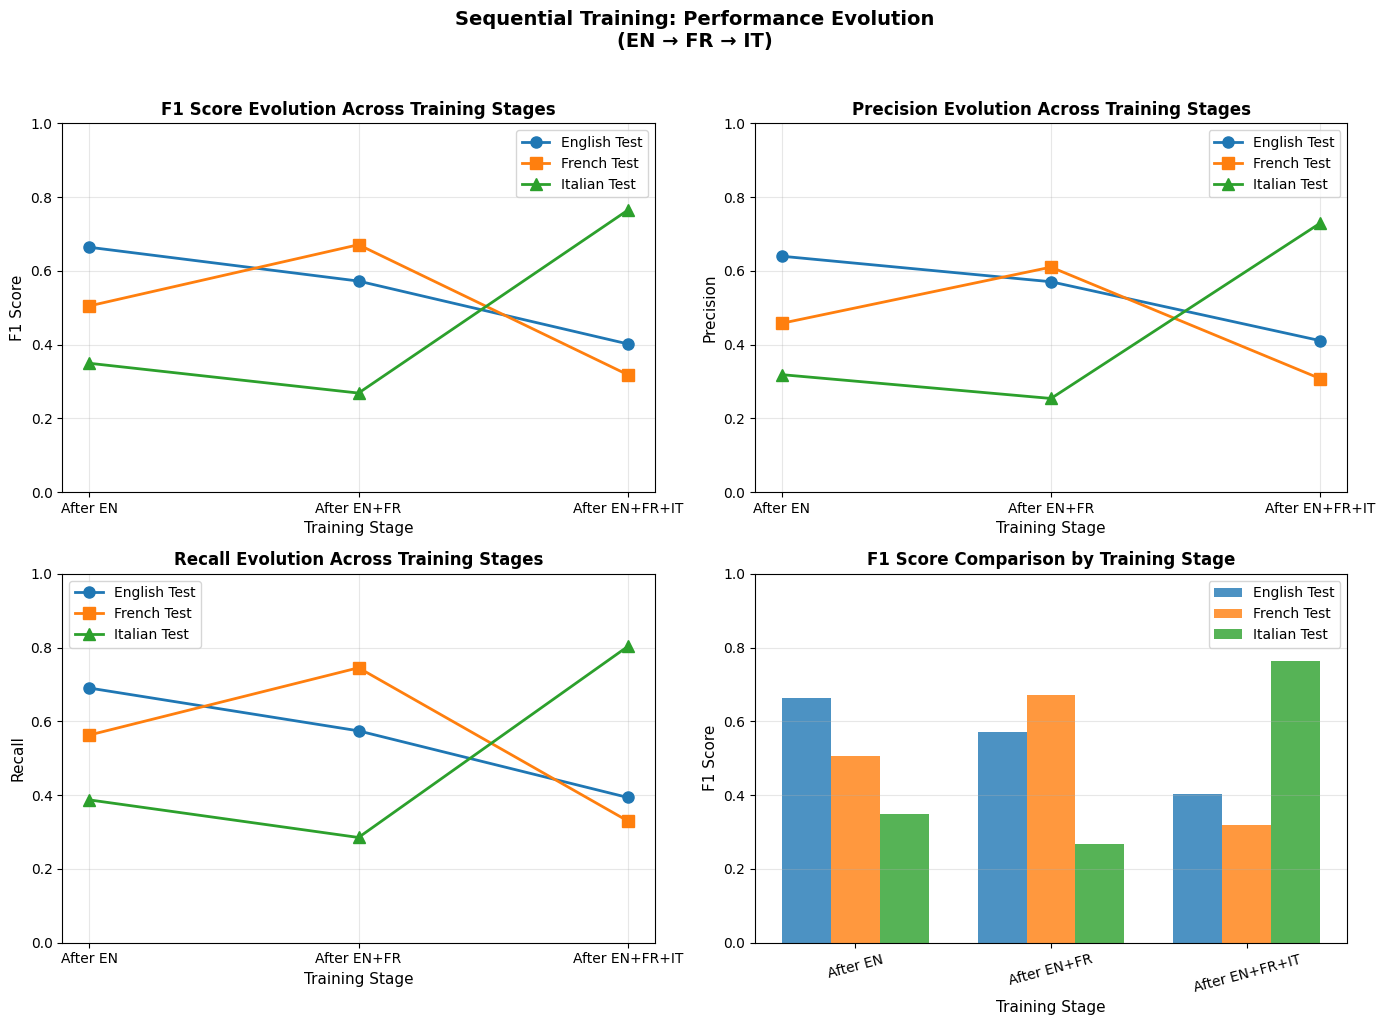

In [17]:
# Create comprehensive visualization of performance evolution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

stages = sequential_results["stages"]
x = np.arange(len(stages))
width = 0.25

colors = {
    "english": "#1f77b4",  # Blue
    "french": "#ff7f0e",   # Orange
    "italian": "#2ca02c"   # Green
}

# Plot 1: F1 Score Evolution (Main metric)
ax1 = axes[0, 0]
ax1.plot(stages, sequential_results["english_test"]["f1"], 
         marker='o', linewidth=2, markersize=8, label='English Test', color=colors["english"])
ax1.plot(stages, sequential_results["french_test"]["f1"], 
         marker='s', linewidth=2, markersize=8, label='French Test', color=colors["french"])
ax1.plot(stages, sequential_results["italian_test"]["f1"], 
         marker='^', linewidth=2, markersize=8, label='Italian Test', color=colors["italian"])
ax1.set_xlabel('Training Stage', fontsize=11)
ax1.set_ylabel('F1 Score', fontsize=11)
ax1.set_title('F1 Score Evolution Across Training Stages', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Precision Evolution
ax2 = axes[0, 1]
ax2.plot(stages, sequential_results["english_test"]["precision"], 
         marker='o', linewidth=2, markersize=8, label='English Test', color=colors["english"])
ax2.plot(stages, sequential_results["french_test"]["precision"], 
         marker='s', linewidth=2, markersize=8, label='French Test', color=colors["french"])
ax2.plot(stages, sequential_results["italian_test"]["precision"], 
         marker='^', linewidth=2, markersize=8, label='Italian Test', color=colors["italian"])
ax2.set_xlabel('Training Stage', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title('Precision Evolution Across Training Stages', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 1])

# Plot 3: Recall Evolution
ax3 = axes[1, 0]
ax3.plot(stages, sequential_results["english_test"]["recall"], 
         marker='o', linewidth=2, markersize=8, label='English Test', color=colors["english"])
ax3.plot(stages, sequential_results["french_test"]["recall"], 
         marker='s', linewidth=2, markersize=8, label='French Test', color=colors["french"])
ax3.plot(stages, sequential_results["italian_test"]["recall"], 
         marker='^', linewidth=2, markersize=8, label='Italian Test', color=colors["italian"])
ax3.set_xlabel('Training Stage', fontsize=11)
ax3.set_ylabel('Recall', fontsize=11)
ax3.set_title('Recall Evolution Across Training Stages', fontsize=12, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(alpha=0.3)
ax3.set_ylim([0, 1])

# Plot 4: Grouped Bar Chart - Final F1 Comparison
ax4 = axes[1, 1]
final_f1 = {
    "English Test": [sequential_results["english_test"]["f1"][i] for i in range(len(stages))],
    "French Test": [sequential_results["french_test"]["f1"][i] for i in range(len(stages))],
    "Italian Test": [sequential_results["italian_test"]["f1"][i] for i in range(len(stages))]
}

x_bar = np.arange(len(stages))
ax4.bar(x_bar - width, final_f1["English Test"], width, label='English Test', color=colors["english"], alpha=0.8)
ax4.bar(x_bar, final_f1["French Test"], width, label='French Test', color=colors["french"], alpha=0.8)
ax4.bar(x_bar + width, final_f1["Italian Test"], width, label='Italian Test', color=colors["italian"], alpha=0.8)
ax4.set_xlabel('Training Stage', fontsize=11)
ax4.set_ylabel('F1 Score', fontsize=11)
ax4.set_title('F1 Score Comparison by Training Stage', fontsize=12, fontweight='bold')
ax4.set_xticks(x_bar)
ax4.set_xticklabels(stages, rotation=15)
ax4.legend(loc='best')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1])

plt.suptitle('Sequential Training: Performance Evolution\n(EN → FR → IT)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_PATH / "sequential_training_evolution.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved visualization to {RESULTS_PATH / 'sequential_training_evolution.png'}")
plt.show()

In [18]:
# Print detailed summary table
print("="*80)
print("SEQUENTIAL TRAINING RESULTS SUMMARY")
print("="*80)

print("\n" + "-"*80)
print("F1 SCORES BY STAGE")
print("-"*80)
print(f"\n{'Stage':<20} {'English Test':<15} {'French Test':<15} {'Italian Test':<15}")
print("-"*65)
for i, stage in enumerate(sequential_results["stages"]):
    en_f1 = sequential_results["english_test"]["f1"][i]
    fr_f1 = sequential_results["french_test"]["f1"][i]
    it_f1 = sequential_results["italian_test"]["f1"][i]
    print(f"{stage:<20} {en_f1:<15.4f} {fr_f1:<15.4f} {it_f1:<15.4f}")

# Calculate and display changes
print("\n" + "-"*80)
print("F1 SCORE CHANGES")
print("-"*80)

def calc_change(values):
    """Calculate change from first to last value."""
    return values[-1] - values[0]

def format_change(val):
    """Format change with sign and color indicator."""
    sign = "+" if val >= 0 else ""
    return f"{sign}{val:.4f}"

print(f"\nChange from 'After EN' to 'After EN+FR+IT':")
print(f"  English Test: {format_change(calc_change(sequential_results['english_test']['f1']))}")
print(f"  French Test:  {format_change(calc_change(sequential_results['french_test']['f1']))}")
print(f"  Italian Test: {format_change(calc_change(sequential_results['italian_test']['f1']))}")

# Insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Check for catastrophic forgetting on English
en_f1_change = calc_change(sequential_results["english_test"]["f1"])
if en_f1_change < -0.05:
    print(f"\n⚠ Potential catastrophic forgetting on English: F1 dropped by {abs(en_f1_change):.4f}")
elif en_f1_change > 0.02:
    print(f"\n✓ Positive transfer to English: F1 improved by {en_f1_change:.4f}")
else:
    print(f"\n○ English performance relatively stable (change: {en_f1_change:.4f})")

# Check cross-lingual transfer
fr_after_en = sequential_results["french_test"]["f1"][0]
it_after_en = sequential_results["italian_test"]["f1"][0]

print(f"\n• Zero-shot performance after English-only training:")
print(f"  French Test F1: {fr_after_en:.4f}")
print(f"  Italian Test F1: {it_after_en:.4f}")

if fr_after_en > 0.3:
    print("  → Significant cross-lingual transfer from English to French")
if it_after_en > 0.3:
    print("  → Significant cross-lingual transfer from English to Italian")

print("\n" + "="*80)

SEQUENTIAL TRAINING RESULTS SUMMARY

--------------------------------------------------------------------------------
F1 SCORES BY STAGE
--------------------------------------------------------------------------------

Stage                English Test    French Test     Italian Test   
-----------------------------------------------------------------
After EN             0.6641          0.5049          0.3495         
After EN+FR          0.5723          0.6709          0.2687         
After EN+FR+IT       0.4020          0.3184          0.7645         

--------------------------------------------------------------------------------
F1 SCORE CHANGES
--------------------------------------------------------------------------------

Change from 'After EN' to 'After EN+FR+IT':
  English Test: -0.2621
  French Test:  -0.1865
  Italian Test: +0.4150

KEY INSIGHTS

⚠ Potential catastrophic forgetting on English: F1 dropped by 0.2621

• Zero-shot performance after English-only training:
  Fr

✓ Saved heatmap to ../results/sequential_training_heatmap.png


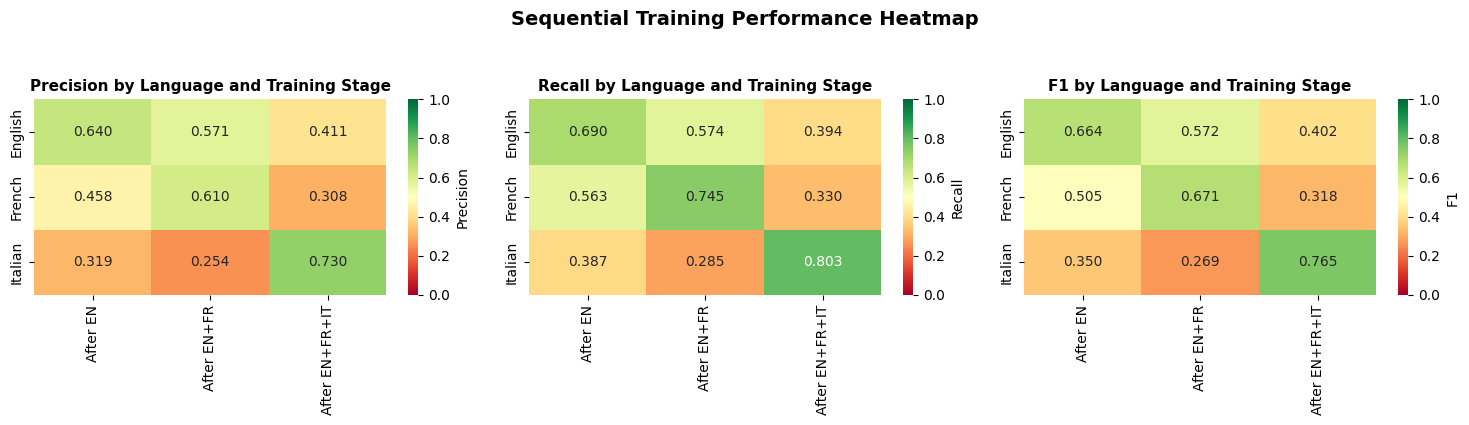

In [19]:
# Create heatmap visualization of all metrics across stages
import pandas as pd

# Create DataFrame for heatmap
metrics_data = []
for i, stage in enumerate(sequential_results["stages"]):
    for lang in ["english", "french", "italian"]:
        for metric in ["precision", "recall", "f1"]:
            metrics_data.append({
                "Stage": stage,
                "Test Set": lang.capitalize(),
                "Metric": metric.capitalize(),
                "Value": sequential_results[f"{lang}_test"][metric][i]
            })

df_metrics = pd.DataFrame(metrics_data)

# Create pivot tables for each metric
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, metric in enumerate(["Precision", "Recall", "F1"]):
    pivot = df_metrics[df_metrics["Metric"] == metric].pivot(
        index="Test Set", columns="Stage", values="Value"
    )
    # Reorder columns
    pivot = pivot[sequential_results["stages"]]
    
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="RdYlGn", 
                vmin=0, vmax=1, ax=axes[idx], cbar_kws={'label': metric})
    axes[idx].set_title(f'{metric} by Language and Training Stage', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

plt.suptitle('Sequential Training Performance Heatmap', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig(RESULTS_PATH / "sequential_training_heatmap.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved heatmap to {RESULTS_PATH / 'sequential_training_heatmap.png'}")
plt.show()

## Summary

**Sequential Training Approach:**
- Train on English → Evaluate all test sets
- Continue training on French → Evaluate all test sets
- Continue training on Italian → Evaluate all test sets

This approach reveals:
1. **Zero-shot cross-lingual transfer**: How well does the model perform on French/Italian after training only on English?
2. **Incremental learning**: Does adding each language's data improve or hurt performance on previously learned languages?
3. **Catastrophic forgetting**: Does the model forget English after training on French and Italian?

**Files created:**
- `models/litbank-xlm-roberta-sequential/` - Final model (trained on EN → FR → IT)
- `results/sequential_training_results.json` - All metrics from each training stage
- `results/sequential_training_evolution.png` - Line plots showing metric evolution
- `results/sequential_training_heatmap.png` - Heatmap comparison

**Next steps:**
Proceed to **Notebook 3: Multilingual Evaluation** for deeper analysis of the final model!